In [63]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from sqlalchemy import create_engine
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
# from sklearn.metrics import fl_source
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_source
from sklearn import svm
from sklearn.linear_model import LogisticRegression
# from skmultilearn.adapt import mlknn
# from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance, LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
import glob
from collections import Counter
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline

In [6]:
data = pd.read_csv('mpst_full_data.csv')
data.columns

Index(['imdb_id', 'title', 'plot_synopsis', 'tags', 'split',
       'synopsis_source'],
      dtype='object')

In [13]:
train = data.drop(columns=['tags'])
train.columns

Index(['imdb_id', 'title', 'plot_synopsis', 'split', 'synopsis_source'], dtype='object')

In [15]:
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [16]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))

In [20]:
tag_dtm = vectorizer.fit_transform(data['tags'])

In [21]:
print("Number of data points:", tag_dtm.shape[0])
print("Number of unique tags:", tag_dtm.shape[1])

Number of data points: 14828
Number of unique tags: 142


In [22]:
tags = vectorizer.get_feature_names()
print("Some of the tags we have:", tags[:10])

Some of the tags we have: [' absurd', ' action', ' adult comedy', ' allegory', ' alternate history', ' alternate reality', ' anti war', ' atmospheric', ' autobiographical', ' avant garde']


In [23]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [25]:
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,absurd,178
1,action,601
2,adult comedy,110
3,allegory,82
4,alternate history,79


In [26]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

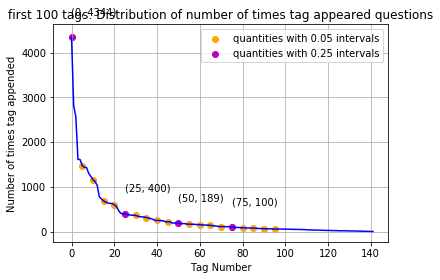

20 [4344 1474 1162  686  601  400  361  314  250  219  189  165  155  139
  113  100   84   78   64   59]


In [29]:
plt.plot(tag_counts, c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label = "quantities with 0.05 intervals")
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantities with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s='({}, {})'.format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag Number")
plt.ylabel("Number of times tag appended")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [30]:
#Storing the count of tag in each question in the list 'tag count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()

#converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count = [int(j) for i in tag_quest_count for j in i]
print('We have total {} datapoints.'.format(len(tag_quest_count)))
print(tag_quest_count[:5])

We have total 14828 datapoints.
[5, 1, 1, 4, 10]


In [32]:
print("Maximum no of tag per question: %d"%max(tag_quest_count))
print("Minimum no of tag per question: %d"%min(tag_quest_count))
print("Avg number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum no of tag per question: 25
Minimum no of tag per question: 1
Avg number of tags per question: 2.981252


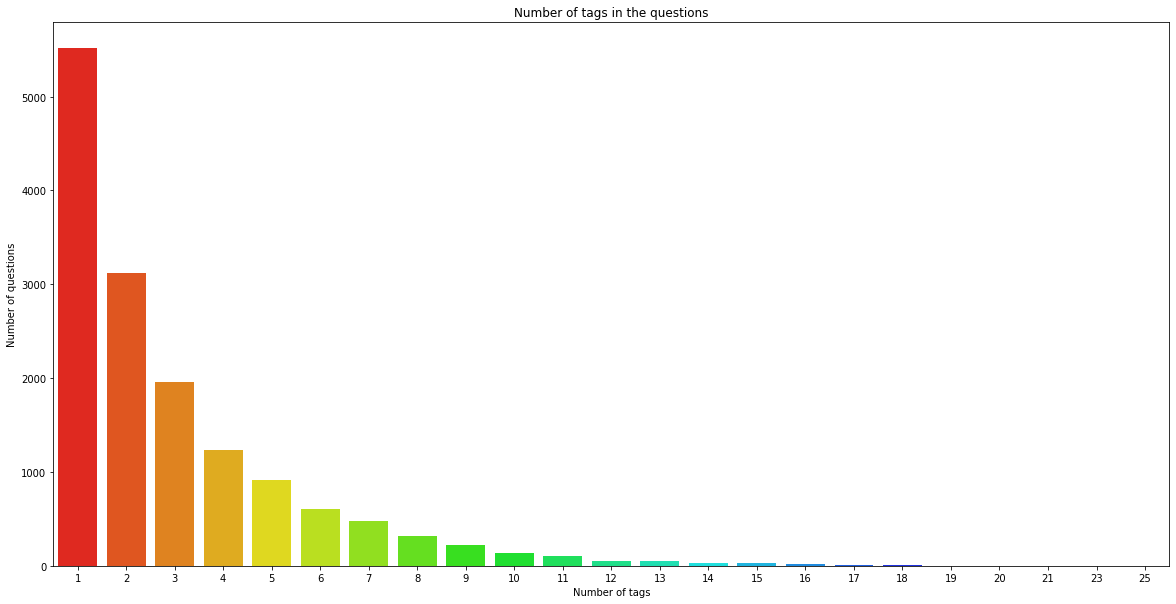

In [34]:
fig = plt.figure(figsize=(20,10))
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions")
plt.xlabel("Number of tags")
plt.ylabel("Number of questions")
plt.show()

<Figure size 1440x720 with 0 Axes>

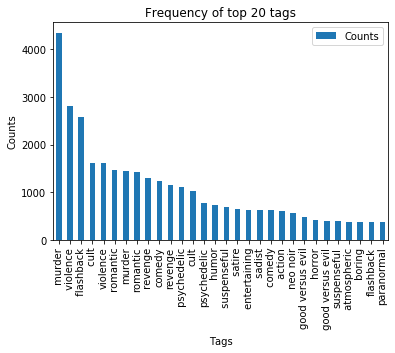

In [36]:
i = np.arange(30)
fig = plt.figure(figsize=(20,10))
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

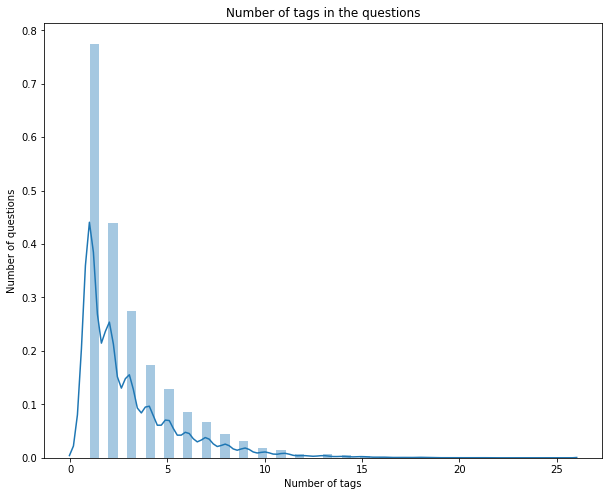

In [37]:
#plot for average no of tags per question

plt.figure(figsize=(10, 8))
plt.subplot()
sns.distplot(tag_quest_count)
plt.title("Number of tags in the questions")
plt.xlabel("Number of tags")
plt.ylabel("Number of questions")
plt.show()

In [53]:
clean_data = data
clean_data.drop(clean_data.index[0], inplace=True)
#Printing first 5 columns from our data frame
clean_data.head()
# print("Time taken to run this cell: ", datetime.now() - start)
# else:
#     print("Run the above cells to generate train_no_dup.db file")

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb
5,tt1315981,A Single Man,George Falconer (Colin Firth) approaches a car...,"romantic, queer, flashback",val,imdb


In [54]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"don't", "do not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", "not", phrase)
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'re", "are", phrase)
    phrase = re.sub(r"\'s", "is", phrase)
    phrase = re.sub(r"\'d", "would", phrase)
    phrase = re.sub(r"\'ll", "will", phrase)
    phrase = re.sub(r"\'m", "am", phrase)
    phrase = re.sub(r"\'ve", "have", phrase)
    return phrase

In [55]:
stopwords = set(["i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself","yourselves","he","him","his","himself",
                 "she","her","hers","herself","it","its","itself","they","them","their","theirs","themselves","what","which","who","whom","this",
                 "that","these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does","did","doing","a",
                 "an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about","against","between","into","through",
                 "during","before","after","above","below","to","from","up","down","in","out","on","off","over","under","again","further","then","once",
                 "here","there","when","where","why","how","all","any","both","each","few","more","most","other","some","such","no","nor","not","only",
                 "own","same","so","than","too","very","s","t","can","will","just","don","should","now"])

In [56]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
#tqdm is for printing the status bar
for sentance in tqdm(clean_data['plot_synopsis'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 14827/14827 [00:30<00:00, 486.49it/s]


In [57]:
clean_data['preprocessed_data'] = preprocessed_reviews

In [59]:
X = clean_data['preprocessed_data']
y = clean_data['tags']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [71]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary='true', max_features = 3)
y_train_vect = vectorizer.fit_transform(y_train)
y_test_vect = vectorizer.transform(y_test)

In [64]:
start = dateime.now()
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', ngram_range=(4, 6), max_features=20000)
x_train_46char = vectorizer.fit_transform(X_train)
x_test_46char = vectorizer.transform(X_test)
print("time taken to run cell: ", datetime.now() - start)

time taken to run cell:  0:43:41.149602


In [78]:
from sklearn.model_selection import GridSearchCV
try:
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced"))
    parameters = { "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0]}
    gsv = GridSearchCV(classifier, param_grid=parameters, scoring='f1_micro',n_jobs=-1)
    gsv.fit(X_train, y_train_vect)
except:
    pass
# print(gsv.best_score_)
# print(gsv.best_params_)
